# ICESat Data Tutorial
---
This notebook is designed to give you a first look at ICESat data (the Ice, Cloud, and land Elevation Satellite). There are a range of data products generated from the raw output of the instrument, which fall into categories defined by the processing level:

* L1a -- Reconstructed, unprocessed data at full resolution (no sane person would ever look at L0 data)
* L1b -- [The lowest level we would ever look at] -- Derived geophysical parameters at the same resolution as the L1a data
* L2  -- [The most common level to use] -- Data, derived from L1b products, that has been spatially or temporally resampled, and analyzed for additional geophysical properties.

<br>
We will be focused on a single L2 product:

* GLAH12  -- Ice Sheet Products (like surface elevation) are stored in the GLAH12 file, which is what we are using here.

Filenames take the following structure: GLAHxx_mmm_prkk_ccc_tttt_s_nn_ffff.h5

* **_mmm_** --  -Release number for process that created the product = 634
* **_p_** --  Repeat ground-track phase (1 = 8-day, 2 = 91-day, 3 = transfer orbit)
* **_r_** --  Reference orbit number; this number starts at 1 and increments each time a new reference orbit ground track file is obtained.
* **_kk_** --  Instance number, incremented every time the satellite enters a different reference orbit.
* **_ccc_** --  Cycle of reference orbit for this phase; the cycle number restarts at 1 every time the instance number changes. The cycle number then increments within the instance (kk) every time Track 1 for that orbit is reached. Most instances begin in an arbitrary track (not 1) because of how the tracks are numbered.
* **_tttt_** --  Track within reference orbit; tracks are defined from a reference orbit. Each track begins and ends at the ascending equator crossing. Tracks are numbered such thatTrack 1 is the closest track to Greenwich Meridian from the east and then contiguousin time after that. For transfer orbits, for which we have no predefined referenceorbit, Track 1 is the first track for which we have data for that instance (kk).
* **_s_** --  Segment of orbit
* **_nn_** --  Granule version number; the number of times this granule is created for a specific release
* **_ffff_** -- File type; numerical, assigned for multiple files as needed for data of same time period for a specific data product; a multifile granule


The data dictionary (which contains a full breakdown of variables) can be found here: https://icesat.gsfc.nasa.gov/icesat/hdf5_products/data_dicts/GLAH12_data_dict.html. 

To look at the data, I start by importing a series of modules that will be useful for reading and plotting the data.

In [1]:
import sys
sys.path.append('/mnt/data01/Code/')
import NDH_Tools as ndh
import glob
import matplotlib.pyplot as plt
import numpy as np

fn = glob.glob('*.H5')
print(fn[0])

GLAH12_634_1102_005_0015_0_01_0001.H5


### The following cell uses a generic hdf5 reader that I've written to read in the data.
That function allows you to provide specific keys, and only load those keys of interest:

In [2]:
ds_dict,orig_dict = ndh.read_h5(fn[0],keylist=['Data_40HZ'],verbose_flag=0)

In [3]:
print(ds_dict['Data_40HZ'].keys())
print(ds_dict['Data_40HZ']['Elevation_Surfaces'].keys())
print(ds_dict['Data_40HZ']['Quality'].keys())
print(ds_dict['Data_40HZ']['Elevation_Corrections'].keys())
print(ds_dict['Data_40HZ']['Geolocation'].keys())

dict_keys(['Atmosphere', 'DS_DEMhiresArElv', 'DS_UTCTime_40', 'Elevation_Angles', 'Elevation_Corrections', 'Elevation_Flags', 'Elevation_Offsets', 'Elevation_Surfaces', 'Geolocation', 'Geophysical', 'Quality', 'Reflectivity', 'Time', 'Transmit_Energy', 'Waveform'])
dict_keys(['d_IceSVar', 'd_elev', 'd_refRng'])
dict_keys(['att_calc_pad_flg', 'att_lpa_flg', 'att_pad_use_flg', 'd_pctSAT', 'elev_use_flg', 'i_satNdx', 'rng_uqf_cent1_flg', 'rng_uqf_cent2_flg', 'rng_uqf_is_flg', 'rng_uqf_ld_flg', 'rng_uqf_oc_flg', 'rng_uqf_si_flg', 'rng_uqf_sigbeg1_flg', 'rng_uqf_sigbeg2_flg', 'rng_uqf_sigend1_flg', 'rng_uqf_sigend2_flg', 'rng_uqf_thres1_flg', 'rng_uqf_thres2_flg', 'sat_corr_flg', 'sigma_att_flg'])
dict_keys(['d_ElevBiasCorr', 'd_GmC', 'd_dTrop', 'd_satElevCorr', 'd_wTrop'])
dict_keys(['d_lat', 'd_lon'])


_
<br><br>
An important note aabout ICESat data -- corrections for tides and the atmosphere are already applied, but a correction for saturation effects must be applied after the fact. That correction is in the 'Elevation_Corrections' group. Below is the text from the data dictionary:
<br><br>
Surface elevation with respect to the ellipsoid at the spot location determined by the ice-sheet specific range after instrument corrections, atmospheric delays and tides have been applied. The saturation elevation correction (d_satElevCorr) has not been applied and needs to be added to this elevation. This can be over a one meter correction. If it is invalid then the elevation should not be used. The saturation correction flag (sat_corr_flg) is an important flag to understand the possible quality of the elevation data. The saturation index (i_satNdx) can be used for more understanding of concerns on data quality from saturation effects. Also no correction for pulse spreading from forward scatter has been applied.
<br><br>
 _
 
 # Now, we can plot the geolocated data for this file!

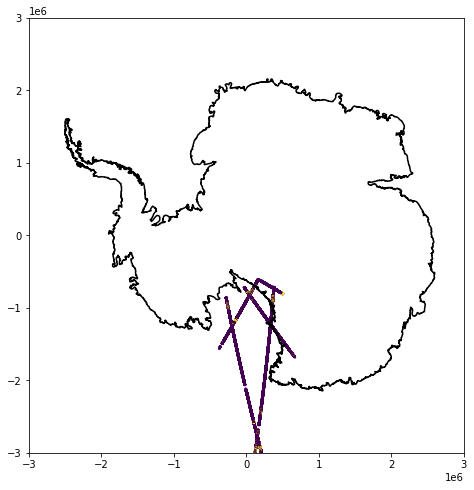

In [13]:
gl = ndh.groundingline(1)
xy_coords = ndh.polarstereo_fwd(ds_dict['Data_40HZ']['Geolocation']['d_lat'],ds_dict['Data_40HZ']['Geolocation']['d_lon'])

ki = np.where(ds_dict['Data_40HZ']['Quality']['elev_use_flg'] == 0)[0]

plt.figure(figsize=(8,8))

plt.plot(gl[:,0],gl[:,1],color='black')
plt.scatter(xy_coords['x'][ki],xy_coords['y'][ki],3,ds_dict['Data_40HZ']['Elevation_Surfaces']['d_elev'][ki]+ds_dict['Data_40HZ']['Elevation_Corrections']['d_satElevCorr'][ki])

plt.xlim([-0.3e7,0.3e7])
plt.ylim([-0.3e7,0.3e7])

plt.gca().set_aspect('equal')